In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
bank_df = pd.read_csv( r'D:\PGDM Marketing IMT 2019-21\Term 4\MLAP\End Term\KNN Practice\bank (1).csv')
bank_df.head(5)

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


## Dealing with the imbalanced datasets

In [4]:
bank_df.subscribed.value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

In [14]:
## Importing resample from *sklearn.utils* package.
from sklearn.utils import resample
# Separate the case of yes-subscribes and no-subscribes
bank_subscribed_no = bank_df[bank_df.subscribed == 'no']
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes']
##Upsample the yes-subscribed cases.
df_minority_upsampled = resample(bank_subscribed_yes,replace=True, n_samples=2000) # sample with replacement
# Combine majority class with upsampled minority class
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])

In [15]:
from sklearn.utils import shuffle
new_bank_df = shuffle(new_bank_df)

In [16]:
new_bank_df.subscribed.value_counts()

no     4000
yes    2000
Name: subscribed, dtype: int64

In [17]:
# Assigning list of all column names in the DataFrame
X_features = list( new_bank_df.columns )
# Remove the response variable from the list
X_features.remove( 'subscribed' )
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [18]:
## get_dummies() will convert all the columns with data type as objects
encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True )
X = encoded_bank_df

In [19]:
# Encoding the subscribed column and assigning to Y
Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )

In [20]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split( X,
Y,
test_size = 0.3,
random_state = 42 )
# Setting random_state a fixed value will guarantee
# that the same sequence of random numbers is generated each time you run the code.

In [21]:
import sklearn as sl

In [22]:
## Importing the KNN classifier algorithm
from sklearn.neighbors import KNeighborsClassifier

In [23]:
## Initializing the classifier
knn_clf = KNeighborsClassifier()

In [24]:
## Fitting the model with the training set
knn_clf.fit( train_X, train_y )
# https://scikitlearn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# p=2 denotes it is Euclidean Distance

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## KNN Accuracy

In [25]:
## Importing the metrics
from sklearn import metrics

In [29]:
## The method takes the three following parameters
## model: the classification model
## test_X: X features of the test set
## test_y: actual labels of the test set
## Returns
## - ROC Auc Score
## - FPR and TPRs for different threshold values
def draw_roc_curve( model, test_X, test_y ):
## Creating and initializing a results DataFrame with actual labels
    test_results_df = pd.DataFrame( { 'actual': test_y } )
    test_results_df = test_results_df.reset_index()
# predict the probabilities on the test set
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )
## selecting the probabilities that the test example belongs to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]
## Invoke roc_curve() to return the fpr, tpr and threshold values.
## threshold values contain values from 0.0 to 1.0
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual,
    test_results_df.chd_1,
    drop_intermediate = False )
## Getting the roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1 )
## Setting the size of the plot
    plt.figure(figsize=(8, 6))
## plotting the actual fpr and tpr values
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    ## plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return auc_score, fpr, tpr, thresholds

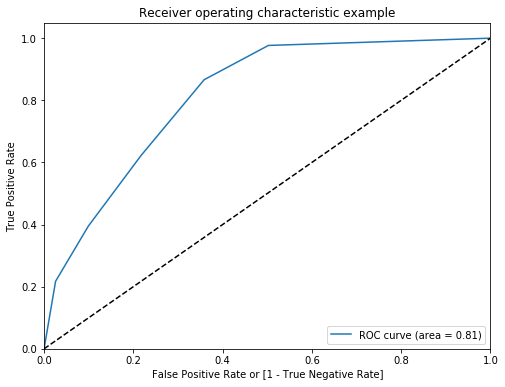

In [30]:
## Invoking draw_roc_curve with the KNN model
_, _, _, _ = draw_roc_curve( knn_clf, test_X, test_y )

In [31]:
## Importing the metrics
from sklearn import metrics
## Defining the matrix to draw the confusion metrix from actual and predicted class labels
def draw_cm( actual, predicted ):
# Invoking confusion_matrix from metric package. The matrix will oriented as[1,0] i.e.
# the classes with label 1 will be reprensted the first row and 0 as secondrow
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
## Confustion will be plotted as heatmap for better visualization
## The lables are configured to better interpretation from the plot
    sn.heatmap(cm, annot=True, fmt='.2f',
    xticklabels = ["Subscribed", "Not Subscribed"] ,
    yticklabels = ["Subscribed", "Not Subscribed"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

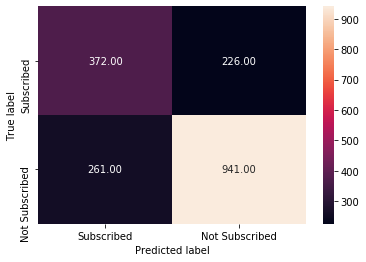

In [32]:
## Predicting on test set
pred_y = knn_clf.predict(test_X)
## Drawing the confusion matrix for KNN model
draw_cm( test_y, pred_y )

In [33]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1202
           1       0.59      0.62      0.60       598

    accuracy                           0.73      1800
   macro avg       0.70      0.70      0.70      1800
weighted avg       0.73      0.73      0.73      1800

